<a href="https://colab.research.google.com/github/mat2hiro/EventBasedCoordinationProtocols/blob/master/self_triggered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resilient Ternary Self-triggered Coordination Protocol

In [2]:
from bisect import *
from collections import deque
from itertools import *
import math
import os
import random
import time
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import seaborn as sns

sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
class TernaryControllerWithMSR:
    def __init__(self, delay_rate, epsilon, f, graph=False, mal_func=(lambda x,t: -1*x), max_size=1, initial_values=[], mal=-1):
        graph.add_nodes_from(
            [(i, {
                'x': initial_values[i] if len(initial_values) > i else np.random.uniform(0,max_size), 'pre_x': -1,
                'u': 0, 'theta': 0, 'last_computed_at': 0,
                'wait': set(), 'collected_val': dict(), 'malicious': False
            }) for i in range(graph.number_of_nodes())])
        for i in range(f if mal < 0 else mal):
            graph.nodes[graph.number_of_nodes()-i-1]['malicious'] = True
            graph.nodes[graph.number_of_nodes()-i-1]['x'] = 0.5 * max_size
        nx.set_edge_attributes(graph,
                               {edge: {'delay': np.random.uniform() * delay_rate}
                                for edge in graph.edges()}
                               )
        self._G_original = graph
        self.G = graph.copy()
        self.n = graph.number_of_nodes()
        self.eps = epsilon
        self.total_time = 0
        self.commands = deque()
        self.commands_time = deque()
        self.f = f
        self.mal_func = mal_func
        self.communication_metadata = {}
        self.max_size = max_size
        self.communication_num = 0
        self.trigger_num = 0

    def _print_progress(self, s):
        time = self.total_time
        print('\rstep%10d: [%s%s] %.4fsec / 20sec' % (s, '#' *
                                                       int(time*2), '-'*(40-int(time*2)), time), end="")

    def _f(self, i, ave, removed):
        return max(
            abs(ave) / 2,
            self.eps
        )

    def _sign(self, i, z):
        zz = float(z)
        return (zz > 0) - (0 > zz) if abs(zz) > self.eps else 0

    def _is_converged(self, step):
        return self.n * 10 < step and all((el == 0 for el in nx.get_node_attributes(self.G, 'u').values()))

    def _time_over(self, max_time):
        return self.total_time > max_time

    # update own control inputs and send messages
    def trigger(self, i, t, node, command):
        if (node['malicious']):
            self.maliciously_behave(i, t, node)
            return
        if command['msr']:
            # apply msr algorithm and calculate average values
            collected_values = np.sort(
                np.array(list(node['collected_val'].values())) - node['x'])
            up_cut = min((collected_values > 0).sum(), self.f)
            down_cut = min((collected_values < 0).sum(), self.f)
            if up_cut == 0:
                collected_values = collected_values[down_cut:]
                removed = down_cut
            else:
                collected_values = collected_values[down_cut:-up_cut]
                removed = up_cut + down_cut
            ave = float(sum(collected_values) / max(len(collected_values), 1))
        else:
            # calculate average values
            removed = 0
            if len(node['collected_val']) == 0:
                ave = 0
            else:
                ave = float(sum(node['collected_val'].values()) /
                            len(node['collected_val']) - node['x'])
        # calculate the next step's properties
        theta = self._f(i, ave, removed)
        u = self._sign(i, ave) if theta != 0 else node['u']
        node['theta'] = theta
        node['u'] = u
        # insert the next operation
        new_t = t + theta
        insert_index = bisect(self.commands_time, new_t)
        self.commands.insert(insert_index, {
            'to': i,
            'callback': self.trigger
        })
        self.commands_time.insert(insert_index, new_t)
        if not node['x'] == node['pre_x']:
            # send messages
            for j in self.G.neighbors(i):
                new_t = t+self.G.edges[i, j]['delay']
                insert_index = bisect(self.commands_time, new_t)
                self.commands.insert(insert_index, {
                    'from': i,
                    'to': j,
                    'value': node['x'],
                    'callback': self.collect
                })
                self.commands_time.insert(insert_index, new_t)
                self.communication_num += 1
            node['pre_x'] = node['x']
            self.communication_metadata[i]['comm'].append(t)
        self.communication_metadata[i]['u'].append(u)
        self.communication_metadata[i]['t'].append(t)
        self.communication_metadata[i]['x'].append(node['x'])
        self.communication_metadata[i]['trigger'].append(t)
        self.trigger_num += 1

    # receive messages
    def collect(self, i, t, node, command):
        node['collected_val'][command['from']] = command['value']

    # update own values
    def compute(self, command, t):
        i = command['to']
        self.total_time = t
        node = self.G.nodes[i]
        diff = t - node['last_computed_at']
        node['x'] += node['u'] * diff
        command['callback'](i, t, node, command)
        node['last_computed_at'] = t
        return i, (t, node, command)

    # run the coordination protocol
    def coordinate(self, step, msr=True, showProg=True, max_time=20):
        self.G = self._G_original.copy()
        self.total_time = 0
        self.trigger_num = 0
        self.communication_num = 0
        self.commands = deque()
        self.commands_time = deque()
        s = 0
        for i in range(self.n):
            # the first operation is to trigger
            self.commands.append({
                'to': i,
                'callback': self.trigger
            })
            self.commands_time.append(0)
        ret = {i: [] for i in range(self.n)}
        # communication metadata
        self.communication_metadata = {i: {'t':[],'x':[],'u':[],'trigger':[],'comm':[]} for i in range(self.n)}
        while(self.commands and s < step and not self._time_over(max_time)):
            command = self.commands.popleft()
            command['msr'] = msr
            t = self.commands_time.popleft()
            val = self.compute(command, t)
            ret[val[0]].append((val[1][0], val[1][1]))
            s += 1
            self.G = self.G.copy()
            if showProg and (s % (-1000 * min(round(math.log10(self.eps)-1), -1)) == 0):
                self._print_progress(s)
        if showProg:
            print('\ntotal steps: %d' % (s))
        return ret, self.communication_metadata, s

    def maliciously_behave(self, i, t, node):
        if len(node['collected_val']) == 0:
            ave = 0
        else:
            ave = float(sum(node['collected_val'].values()) /
                        len(node['collected_val']) - node['x'])
        theta = self.eps
        u = self.mal_func(self._sign(i, ave), t) if theta != 0 else node['u']
        node['theta'] = theta
        node['u'] = u
        new_t = t + theta
        insert_index = bisect(self.commands_time, new_t)
        self.commands.insert(insert_index, {
            'to': i,
            'callback': self.trigger
        })
        self.commands_time.insert(insert_index, new_t)
        for j in self.G.neighbors(i):
            new_t = t+self.G.edges[i, j]['delay']
            insert_index = bisect(self.commands_time, new_t)
            self.commands.insert(insert_index, {
                'from': i,
                'to': j,
                'value': node['x'],
                'callback': self.collect
            })
            self.commands_time.insert(insert_index, new_t)
        self.communication_metadata[i]['t'].append(t)
        self.communication_metadata[i]['x'].append(node['x'])


In [24]:
# draws agents' control values
def draw_node_values(ret, max_time=10, m="", l="-"):
    plt.title("agents' values")
    plt.xlim(0, max_time)
    plt.xlabel("t")
    plt.ylabel("x")
    for i in ret:
        times = [r[0] for r in ret[i]]
        vals = [r[1]['x'] for r in ret[i]]
        plt.plot(times, vals, label='%d' % i, marker=m, linestyle=l)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0)
    plt.show()

# draws agents' control inputs
def draw_node_inputs(ret, max_time=10):
    n = len(ret) - 1
    plt.figure(figsize=(6, 2*n))
    plt.title("agents' inputs")
    for i in range(n):
        plt.subplot(n, 1, i+1)
        plt.xlim(0, max_time)
        plt.ylim(-1.1, 1.1)
        times = [r[0] for r in ret[i]]
        vals = [r[1]['u'] for r in ret[i]]
        plt.plot(times, vals)
        plt.title('%d' % i)
    plt.tight_layout()
    plt.show()


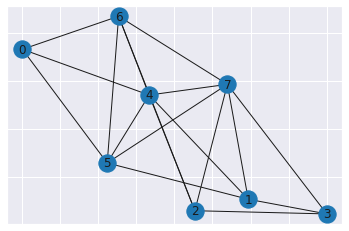


total steps: 1585


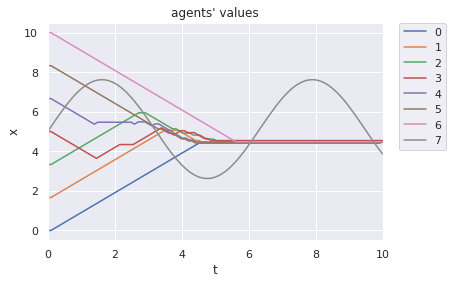

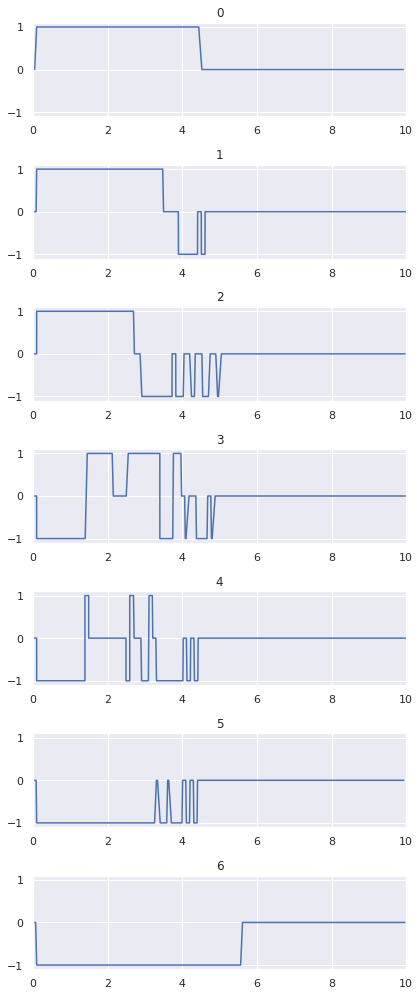

In [26]:
# define the malicious behavior
def mf(x, t):
    return 2.5*math.cos(t)

np.random.seed(14612)

# 3-robust graph
n_c = 8
GG = nx.Graph()
GG.add_edges_from([(0,4),(0,5),(0,6),(1,3),(1,4),(1,5),(1,7),(2,3),(2,4),(2,6),(2,7),(3,7),(4,5),(4,6),(4,7),(5,6),(5,7),(6,7)])

# model instance
tc_msr = TernaryControllerWithMSR(0.1, 0.1, 1, graph=GG, mal_func=mf, max_size=10, initial_values=np.linspace(0,10,n_c-1), mal=1)

# draw the network topology
nx.draw_networkx(tc_msr.G)
plt.show()

# set termination time and run the protocol
mt = 10
ret_msr, _, _ = tc_msr.coordinate(step=float('inf'), msr=True, max_time=mt)

# draw the result
draw_node_values(ret_msr, mt)
draw_node_inputs(ret_msr, mt)